In [1]:
# Imports used in the report
from featimp import *
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display

# Feature Importance

***

Feature importance describes any method that attempts to analyze the features in a data set and score them based on their relevance. Simple strategies tend to focus on how the features correlate with the target variable or the amount of variance in the target that can be explained by the input. The first few strategies I'll cover are common approaches using this method, which are the Spearman's rank correlation coefficient, princial component analysis (PCA), and minimal-redundancy-maximal-relevance (mRMR).

Other strategies tend to focus on using different models and metrics to analyze the importance of each input features. The idea comes from the fact that different models may fit better to a different set of input features. Then, we can use our validation metrics to measure our success on the subset.

Lastly, I'll experiment comparing strategies to illustrate which ones perform best on the data set. Then, purpose a method for automatically selecting the best subset of features for any data set, given a specific model and feature importance strategy.

Almost all the functions used in this notebook are built from scratch to implement each of these feature importance strategies, so please make sure to check out the associate python file featimp.py to see the details.

## Data Set: Car Prices

***

The toy data set that I will use throughout this notebook is the following car data set with various features about a car as the input features and the price of the car as the target.

In [2]:
cars = pd.read_csv('cars.csv')
cars.head(5)

,wheel-base,num-of-doors,num-of-cylinders,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,88.6,2,4,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495
1,88.6,2,4,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500
2,94.5,2,6,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500
3,99.8,4,4,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950
4,99.4,4,5,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450


## Spearman's Rank Correlation

***

Spearman's rank correlation is one of the simplest methods of feature importance that looks directly at the data itself. First, we need to rank each of the features from smallest to largest. Then we measure the correlation between each input feature and the target. Lastly, we sort the correlations by their magnitude from largest to smallest. 

This strategy works well with single feature importance, since it measures each feature independently, but does not work well for highly correlated features. Features that are correlated will have similar ranks, even though we don't need both. This strategy also does not work with categorical variables since we can't rank them from smallest to largest, which makes the correlation not make sense. However, we can use ordinal categorical variables like 'num-of-cylinders' and 'num-of-doors' since we can order them.

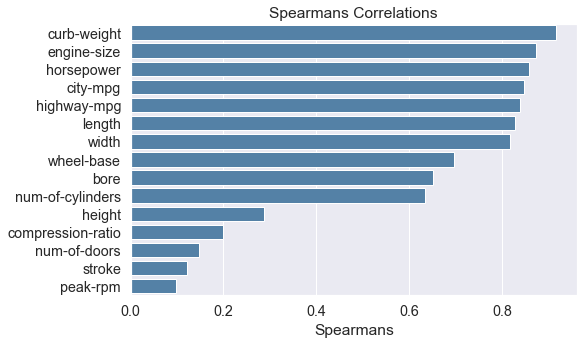

In [3]:
spearmans = spear(rank_col(cars), target_col='price')
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(8,5)}, font_scale=1.3)
ax = sns.barplot(x='Spearmans', y=spearmans.index, data=spearmans, color='steelblue')
ax.set(title='Spearmans Correlations');

## Principal Component Analysis (PCA)

***

PCA is method of reducing the dimensionality of the input matrix into lower dimensions. Essentially, we can think of the data as vectors that we project onto a lower dimension, while trying to preserve the most important parts of the original data. This method analyzes the variance of each input feature which is one way to measure importance since intuitively, we don't want our data to be homogenous. However, data with high variance isn't always the most important. This is another example where categorical variables also will not provide meaningful results.

First, I've reduced the diensionality into two components and then found the explained variance of each component. Explained variance means how much the total variance of the components is made up of each component:

In [4]:
Exp, Loads = PCA(cars, target='price', components=2)
Exp.set_index('PC')

,Explained Variance
PC,
PC_1,0.649982
PC_2,0.350018


Here we can see that the first principal component has the higher explained variance. Then we take first component and measure the correlation between it and the input features to measure 'loads'. The highest 'load' variables are given higher importance.

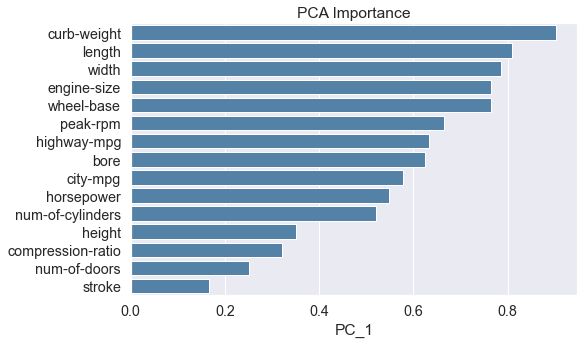

In [5]:
# Sort by highest loads
Loads = Loads.sort_values(by='PC_1', ascending=False)
ax = sns.barplot(x='PC_1', y=Loads.index, data=Loads, color='steelblue')
ax.set(title='PCA Importance');

Seems like curb-weight is the most important again, but we also have a few new features at the top compared to Spearman's method.

## Minimal-Redundancy-Maximum-Relevance (mRMR)

***

The methods we have mentioned so far have the common issue of single feature importance, where we look at one feature at a time to assess importance. This means that similar features might end up with a similar score. We don't want to have repeat features if we can represent the same information using one feature. 

The mRMR method addresses this issue by not only analyzing **relevance**, but also **redundacy**. In this version of mRMR, for relevance, we calculate the F-statistic between the input feature and the target. Then find the redundancy by calculating the average correlation between the new feature and features that have already been selected. At each iteration, we select the feature with the highest score. The equation is as follows:

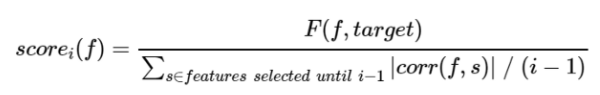

In [6]:
display.Image(filename='mrmr.png')

We also need to choose how many features we want to select:

In [3]:
X = cars.drop(columns=['price'])
y = cars['price']

MRMR = mrmr(X, y, k_features=8)
pd.DataFrame(MRMR, columns=['Selected_Features'])

,Selected_Features
0,curb-weight
1,peak-rpm
2,horsepower
3,engine-size
4,length
5,compression-ratio
6,highway-mpg
7,wheel-base


Since this method is iteratively calculating new scores for the remaining features at each step, it doesn't make sense to plot the score for each feature. This makes it difficult to compare how important 'curb-weight' is compared to 'peak-rpm', but does a better job reducing useless correlated features. For more details on implementation, check out the associate python file.

## Drop Column Importance

***

This is the first strategy I'll cover that employs the model-based importance strategy. The idea behind drop column importance is that we start with the full data set, then drop each input feature once, refit the model, and assess how much our model metric has dropped. This can work for any machine learning model and any metric, but for this example, I use a random forest and R^2 as the metric to measure importance.

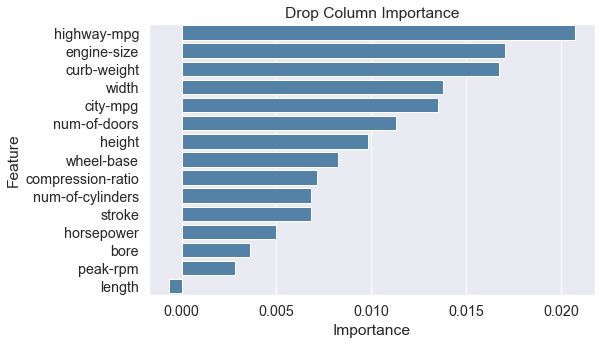

In [8]:
drop = drop_col_importance(X, y)
ax = sns.barplot(x='Importance', y=drop.index, data=drop, color='steelblue')
ax.set(title='Drop Column Importance');

Even when using different methods, 'curb-weight' still seems to be one of the top important features. The negatives are a signal that dropping those features may actually improve our model. Using drop column importance is one way we can remove unessesary noise that may be negatively influencing our models.

The downside of this method is that we have to train a new model for each feature we drop, which can be expensive. Correlated features are also still a problem because when we drop one correlated feature, the other will cover for it and keep our metric the same.

## Permutation Importance

***

Similar to drop column importance, but instead of droping each column one at a time, we shuffle the validation column so that the distribution of values stays when we train the model, but the relationships are broken. Again, using random forest and the R^2 metric, here are the results:

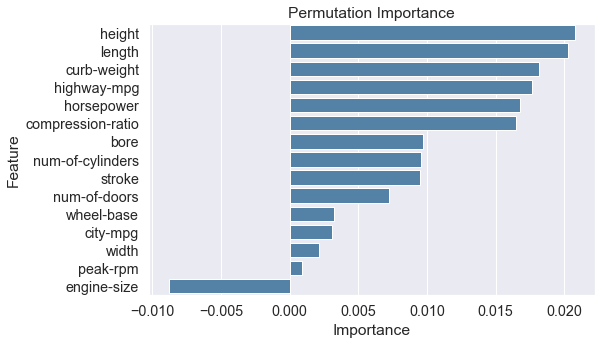

In [9]:
perm = perm_importance(X,y)
ax = sns.barplot(x='Importance', y=perm.index, data=perm, color='steelblue')
ax.set(title='Permutation Importance');

The benefits to this method are similar to drop column importance since it works for any machine learning model as well and is easy to interpret. However, they both suffer the same consequence of not working well on correlated features. In this case, the correlated features may show similar importance. The main benefit of permutation importance over dropping columns is that there is no need to retain the model during every iteration, so the cost is much less expensive when working with many features.

## Comparing Strategies

***

Now that we have reviewed a few different strategies for feature selection, how do we know which one works best? The key is that it depends on the data set and model we're using. We can attempt to test how our chosen model performs using each strategy by comparing using the same model validation metric on the top features selected by each model.

The idea is to take all our strateties, get the sorted selected features, and fit a model to the top features. We start with only fitting to the best feature identified by each strategy, then add the next selected feature and compare to see how the model performs on these subsets using each strategy. In this example, I compare all the strategies we've discussed so far and compared the outcomes using the mean absolute error (MAE).

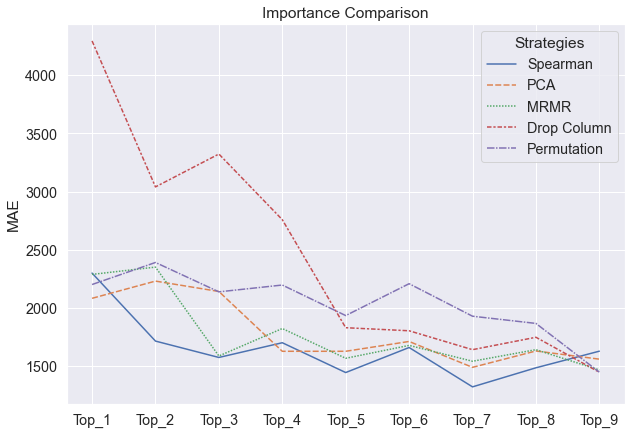

In [15]:
compare = compare_top_k(X, y, cars, top_k=9)
sns.set(rc={'figure.figsize':(10,7)}, font_scale=1.3)
ax = sns.lineplot(data=compare.T)
ax.set(title='Importance Comparison', ylabel='MAE');

From here we can see that our strategies can produce slightly different results because each strategy has a differnt way to measure importance. It seems like we should stick with the top 7 features using Spearman's correlation to rank importance, since it show the lowest MAE.

## Automatic Feature Selection

***

Now that we can rank our features by importance, we need a way to select the best subset to use for our final model. Most of the time we can use a subset of our input features data to achieve similar or better results. Needing less data means we can achieve faster training times, increase interpretability, and reduce noise and codependent variables. To illustrate, I'll use the following procedure to show how the model performs by dropping the least important features one at a time:

1. Sort the features from least to most important
2. Start dropping the features one at a time
3. Retrain a random forest using the remaining features
4. Plot the R^2 value at each iteration

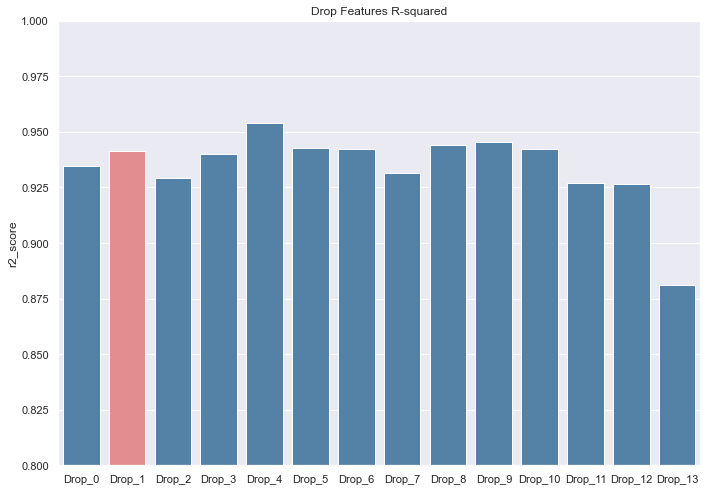

In [36]:
dropped = drop_analysis(X, y, df=cars)
clrs = ['steelblue' if x != 'Drop_1' else 'lightcoral' for x in dropped.index]
ax = sns.barplot(x=dropped.index, y=dropped['r2_score'], data=dropped, palette=clrs)
ax.set(title='Drop Features R-squared')
sns.set(rc={'figure.figsize':(10,7)}, font_scale=1)
plt.ylim(0.8, 1)
plt.tight_layout();

Our automated feature selection algorithm will start start with the baseline of the full model and then repeat the following:

1. While the R^2 score doesn't decrease, repeat steps 2-4
2. Recalculate feature importances and drop the least important feature
3. Refit the model and calculate the new R^2
4. If the new R^2 is worse, then stop and readd the most recently removed feature

On the above chart, we can see that once we drop more than one column, our R^2 score starts to decrease, so our automated feature selection will stop there. It's interesting to see that dropping more features eventually makes the R^2 score increase to be higher than our baseline. This could be the fact that we are working with a small data set, or because there are lots of correlated or codependent features in this data set.

A different approach to select the minimum number of features required would be to work backwards and start from the most important feature. Then add the next most important feature until we meet or exceed the R^2 validation metric for the baseline model using all input features.

For this report, I have implemented the first approach using permutation importance. Feel free to review the python file for implementation details:

In [12]:
pd.DataFrame(automated_feature_selection(X, y), columns=['Selected Features'])

,Selected Features
0,bore
1,compression-ratio
2,stroke
3,num-of-doors
4,width
5,wheel-base
6,length
7,horsepower
8,num-of-cylinders
9,curb-weight


From this list we can see that 'engine-size' was dropped from the selected features and was deemed unnecessary by our algorithm because it improved our model by dropping it. If we look back at the our implementation of permutation importance, we can see that 'engine-size' was also the one feature that actually improved our R^2 when shuffled.

## Confidence in Important Features

***

How do we know our features are actually important? To answer this question, we can examine how likely a feature is to be important by chance. First, we set our target feature importance for a given feature using one of our importance strategies. Then, we shuffle our target variable and recalculate the input features importance. We repeat the shuffle and importance calculation until we establish a distribution of importances for the feature that happen by chance. If at least 5% of these random importances are just as important or more important than our original importance, then we conclude that our feature is not important since it can be deemed important by chance. The 5% is essentially our significance level and we are trying to find if the probability of the feature being as important or greater than our significance level (p-value). Now, let's plot the distribution and see how it matches our target value for a given input feature. The red lines are the baseline targets using the actual full model.

In [4]:
iterations = 300
targets, dist = get_distribution_targets(cars, iterations=iterations)

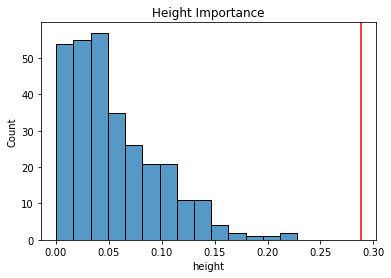

In [13]:
# Pick a feature
feature = 'height'
# Actual importance
act_imp = float(targets.loc[feature])

ax = sns.histplot(data=dist[feature])
plt.axvline(x=act_imp, color='red')
ax.set(title='Height Importance');

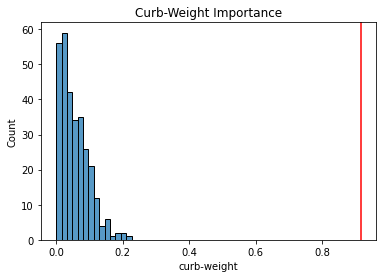

In [14]:
# Pick a feature
feature = 'curb-weight'
# Actual importance
act_imp = float(targets.loc[feature])

ax = sns.histplot(data=dist[feature])
plt.axvline(x=act_imp, color='red')
ax.set(title='Curb-Weight Importance');

Looking at the results, it seems that both 'height' and 'curb-weight' are both important features since shuffling the 'price' target significantly reduced the distribution of importance. This means we conclude that these features are not important by chance. In this instance there's no need to calculate the p-values, because we can see from the graph that none of the values from the shuffled distributions are above the red line targets. As a note, the reason the distributions do not go below zero is because we take the absolute value of Spearman's importance, since we are only interested in the strength or magnitude of the correlation and not the sign.

## Conclusion

***

In this report we discussed a few methods and implementations of feature importance using the features themselves and model importances. Then compared the strengths and weaknesses of each method while evaluating which methods preformed best for our data set. We also implemented an algorithm that selects the best subset of features that doesn't decrease our validation metric. Lastly, we used basic statistical methods to analyze whether our selected features are actually important, or deemed important by our stategies due to chance.

## References

***

1. Principal Component Analysis: https://www.askpython.com/python/examples/principal-component-analysis
2. “MRMR” Explained Exactly How You Wished Someone Explained to You: https://towardsdatascience.com/mrmr-explained-exactly-how-you-wished-someone-explained-to-you-9cf4ed27458b